In [6]:
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

from IPython.display import Audio
%matplotlib inline

# Intro to MIR

## Part 1: Discrete Fourier Transform and friends

In [110]:
def create_sine(frequency, a=1, dur=1, sr=22050):
    """
    creates a sine wave
    
    Args:
        frequency (int): number of cycles per second (Hz)
        a (int): amplitude of signal
        dur (int): duration of signal in seconds
        sr (int): samplerate of signal        
    """
    return a*np.sin(np.arange(dur*sr) / sr * 2 * np.pi * frequency)

In [111]:
sr = 22050

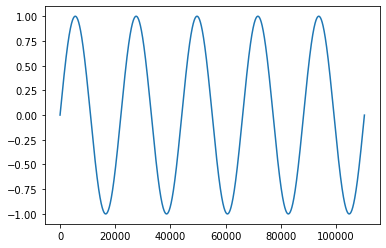

In [112]:
sig = create_sine(1, dur=5)
plt.plot(sig);

In [113]:
Audio(data=sig, rate=sr)

hmmm, why isn't this working? Let's try with a different frequency...

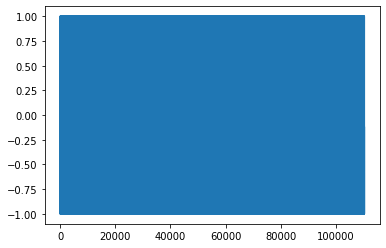

In [114]:
sig = create_sine(440, dur=5)
plt.plot(sig);

In [115]:
Audio(data=sig, rate=sr)

In [116]:
def plot_dft(sig, win_len=1024):
    window = np.hamming(win_len)
    sig = window * sig[:win_len]
    D = np.abs(np.fft.fft(sig))[:win_len//2]
    xs = np.arange(win_len/2) * (22050/win_len)
    plt.plot(xs, D)

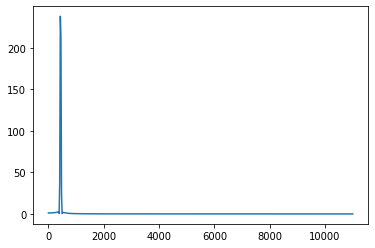

In [117]:
plot_dft(sig)

Cool, let's build a more complex signal!

In [143]:
sig = create_sine(440) + create_sine(1760, a=0.6)
Audio(data=sig, rate=sr)

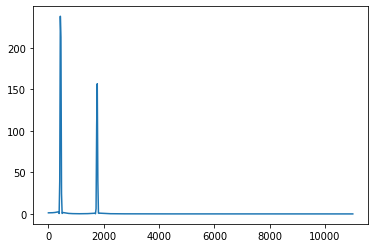

In [144]:
plot_dft(sig)

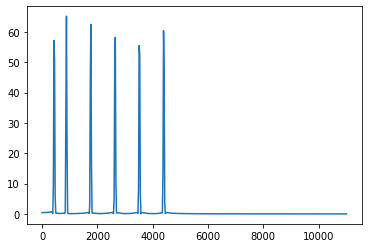

In [153]:
f0 = 440
sig = 0
for i in [1, 2, 4, 6, 8, 10]:
    sig += create_sine(f0*i)
sig /= np.max(np.abs(sig))
plot_dft(sig)

In [148]:
Audio(data=sig, rate=sr)

ok, let's let's try some music!

## Let's look at some music

In [76]:
filename = librosa.util.example_audio_file()
y, sr = librosa.core.load(filename)

In [ ]:
Audio(data=y, rate=sr)

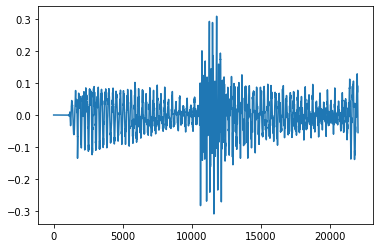

In [127]:
plt.plot(y[:sr]);

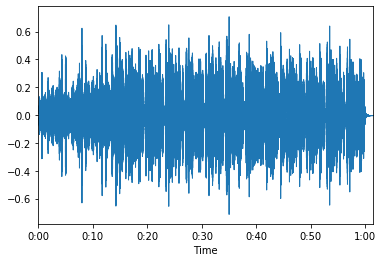

In [128]:
librosa.display.waveplot(y, sr);

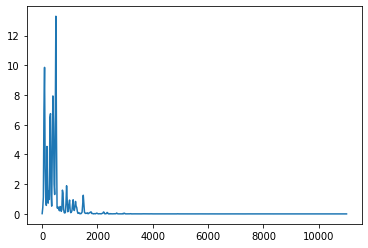

In [155]:
plot_dft(y[sr*5:])

In [131]:
def plot_stft(sig):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sig)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear');

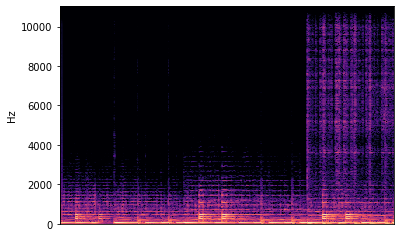

In [133]:
plot_stft(y[:sr*10])

In [137]:
def plot_mel_specgtrogram(y):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr);



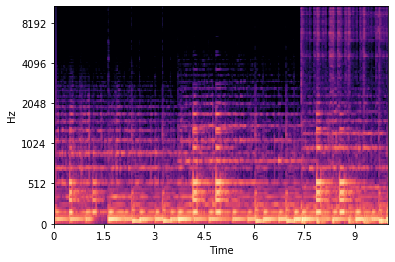

In [138]:
plot_mel_specgtrogram(y[:sr*10])

phew! that's enough plotting for now, let's take a break

## Part 2: Features

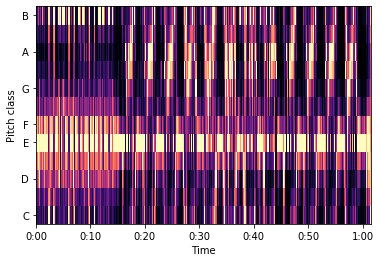

In [157]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')

In [170]:
chroma.shape

(12, 2647)

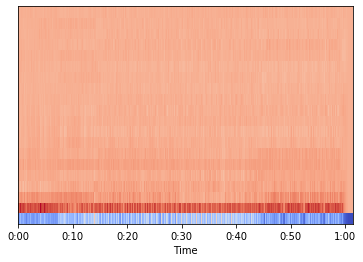

In [163]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
librosa.display.specshow(mfccs, x_axis='time')

In [169]:
a = mfccs.mean(axis=1)
b = mfccs.std(axis=1)
np.concatenate([a,b]).shape

(40,)

In [174]:
def extract_mfccs(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    return np.concatenate([
        mfccs.mean(axis=1),
        mfccs.std(axis=1)
    ])

def extract_chroma(y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return np.concatenate([
        chroma.mean(axis=1),
        chroma.std(axis=1)
    ])

def extract_feats(y, sr):
    chroma = extract_chroma(y, sr)
    mfccs = extract_mfccs(y, sr)
    feats = np.concatenate([chroma, mfccs])
    
    labels = []   
    for i in range(len(chroma) // 2):
        labels.append('chroma_{}_mean'.format(i))
    for i in range(len(chroma) // 2):
        labels.append('chroma_{}_std'.format(i))
    for i in range(len(mfccs) // 2):
        labels.append('mfcc_{}_mean'.format(i))
    for i in range(len(mfccs) // 2):
        labels.append('mfcc_{}_std'.format(i))
        
    return feats, labels

In [175]:
feats, labels = extract_feats(y, sr)

## Classification

In [231]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [178]:
import os

In [193]:
def feats_for_fname(fname):
    y, sr = librosa.core.load(fname)
    return extract_feats(y, sr)

In [194]:
def fname_generator(genre):
    for root, dirs, files in os.walk('genres/'):
        for file in files:
            if file.endswith('.wav') and genre in file:
                yield os.path.join(root, file)            

In [218]:
def df_for_genre(genre):
    fnames = []
    feats = []
    for fname in fname_generator(genre):
        # print("extracting feats for {}".format(fname))
        cur_feats, labels = feats_for_fname(fname)
        fnames.append(fname)
        feats.append(cur_feats)
    df = pd.DataFrame(feats, columns=labels, index=fnames)
    df['label'] = genre
    return df

In [245]:
data = pd.concat([df_for_genre(genre) for genre in ['pop', 'reggae']])

In [246]:
y = data['label']
X = data.drop('label', axis=1)

In [247]:
X.shape

(200, 64)

In [248]:
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [250]:
pipeline.fit(X_train, y_train)

/Users/derek/code/lib/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [251]:
y_pred = pipeline.predict(X_test)

In [252]:
accuracy_score(y_test, y_pred)

0.875